In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' # uncomment this line if omp error occurs on OSX for python 3
os.environ['OMP_NUM_THREADS']='28' # set number of OpenMP threads to run in parallel
os.environ['MKL_NUM_THREADS']='28' # set number of MKL threads to run in parallel

In [2]:
import time
from quspin.operators import hamiltonian, quantum_operator, exp_op  # Hamiltonians and operators
from quspin.basis import spin_basis_1d  # Hilbert space spin basis
from quspin.tools.evolution import expm_multiply_parallel
import numpy as np  # generic math functions
import matplotlib.pyplot as plt
from scipy.optimize import minimize, basinhopping
from datetime import date
import multiprocessing as mp
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs
import random
from math import pi

参数表

In [3]:
time_start = time.time()
n = 4 # 行
m = n # 列
n_qubit = n*m + n
a = 1
mass = 10
g = 3
chemical_potential = 150
basis = spin_basis_1d(n_qubit)
layers = 10
H_number = 3
# print(basis)

pauli_x = np.array([[0,1],[1,0]]) # Pauli matrix
pauli_y = np.array([[0,-1j],[1j,0]])
pauli_z = np.array([[1,0],[0,-1]])

定义相互作用形式

In [4]:
# define one Pauli matrices
def h_n(Interaction_form: str, position: int, Coefficient=1):
    """this function is one Pauli matrices, return hamiltonian.
    need choose basis first!!!
    first parameter is interaction form, you can input 'x','y','z','I'.
    second parameter is coefficient before,
    last two parameter is lattice position,
     """
    h_list = [[Coefficient, position]]
    h_op = [[Interaction_form, h_list]]
    dynamic = []
    ham = hamiltonian(static_list=h_op, dynamic_list=dynamic,
                      dtype=np.complex128, basis=basis, check_herm=False, check_symm=False)
    return ham

# define two Pauli matrices interaction
def h_nn(Interaction_form: str, position1: int, position2: int, Coefficient=1):
    """this function is two Pauli matrices interaction, return hamiltonian.
    need choose basis first!!!
    first parameter is interaction form, you can input 'xx','yy','zz'...
    second parameter is coefficient before,
    last two parameter is lattice position,
     """
    h_list = [[Coefficient, position1, position2]]
    h_op = [[Interaction_form, h_list]]
    dynamic = []
    ham = hamiltonian(static_list=h_op, dynamic_list=dynamic,
                      dtype=np.complex128, basis=basis, check_herm=False, check_symm=False)
    return ham

# Jordan-Wigner transf.
def JWtransf(i:int):
    """J-W transf. phi_i = 1/2 * (X_i - i*Y_i) * sum_k=0^i-1 (-i*Z_k)"""
    res = (h_n('x',i) - h_n('y',i,1j))/2
    for k in range(i): # sum部分
        res = res * h_n('z',k,1j)
    return res

# define phi dagger phi
def pdaggerp(LN_i:int,LN_j:int):
    """直接手算了psidagger psi得到的具体形式，args LN_i(LN_j) mean LN_i(LN_j) th lattice number: LN_i*m + j"""
    if LN_i==LN_j:
        return (h_n('I',LN_i) + h_n('z',LN_i)) / 2
    elif LN_i>LN_j:
        temp = -1j/4 * (h_n('x',LN_i) + h_n('y',LN_i,1j)) * (h_n('x',LN_j) - h_n('y',LN_j,1j))
        for k in range(LN_j+1,LN_i):
            temp *= h_n('z',k,1j)
        return temp
    elif LN_i<LN_j:
        temp = 1j/4 * (h_n('x',LN_i) + h_n('y',LN_i,1j)) * (h_n('x',LN_j) - h_n('y',LN_j,1j))
        for k in range(LN_i+1,LN_j):
            temp *= h_n('z',k,-1j)
        return temp

def pdaggerp_m_hc(LN_i:int,LN_j:int): # J-W transf. 这个算符是反厄密的
    return pdaggerp(LN_i,LN_j) - pdaggerp(LN_j,LN_i)

def pdaggerp_p_hc(LN_i:int,LN_j:int): # J-W transf. 这个算符是厄密的
    return pdaggerp(LN_i,LN_j) + pdaggerp(LN_j,LN_i)

构造哈密顿量

In [5]:
def T1(rho_index):
    rho_vetor = np.array([int(rho_index/2),rho_index%2])
    # print(rho_vetor)
    res = np.identity(2)
    for i in range(rho_vetor[0]+rho_vetor[1]):
        res = np.dot(res,pauli_x)
    for i in range(rho_vetor[0]):
        res = np.dot(res,pauli_y)
    for i in range(rho_vetor[1]):
        res = np.dot(res,pauli_z)
    return res

def T2(rho_index):
    rho_vetor = np.array([int(rho_index/2),rho_index%2])
    # print(rho_vetor)
    res = np.identity(2)
    for i in range(rho_vetor[0]+rho_vetor[1] + 1):
        res = np.dot(res,pauli_x)
    for i in range(rho_vetor[0]):
        res = np.dot(res,pauli_y)
    for i in range(rho_vetor[1]):
        res = np.dot(res,pauli_z)
    return res

def U1(): # 这里的代码要求只能是2*2的T，其实我定义T1，T2时就已经只用Pauli matrices了
    res = np.zeros((4,4),dtype=np.complex128)
    for alphabeta_index in range(4):
        alpha = int(alphabeta_index / 2)
        beta = int(alphabeta_index % 2)
        for rho_index in range(4):
            res[alphabeta_index,rho_index] = T1(rho_index=rho_index)[alpha,beta]
    return res/np.sqrt(2)

def U2(): # 这里的代码要求只能是2*2的T，其实我定义T1，T2时就已经只用Pauli matrices了
    res = np.zeros((4,4),dtype=np.complex128)
    for alphabeta_index in range(4):
        alpha = int(alphabeta_index / 2)
        beta = int(alphabeta_index % 2)
        for rho_index in range(4):
            res[alphabeta_index,rho_index] = T2(rho_index=rho_index)[alpha,beta]
    return res/np.sqrt(2)

In [6]:
def HI(psi_index): # -m * psibar psi
    res = 0
    if psi_index == 1:
        temp = np.dot(np.dot(np.conjugate(U1().T),np.kron(pauli_x,pauli_x)),U1()) # 实际上就只是一个矩阵
    elif psi_index ==2:
        temp = np.dot(np.dot(np.conjugate(U2().T),np.kron(pauli_x,pauli_x)),U2())
    else:
        print('error psi index')
    for N_x in range(int(n/2)): #遍历空间点
        for N_y in range(int(m/2)):
            temp_res = 0
            for rho1 in range(2*2):
                rho1_x = int(rho1/2)
                rho1_y = int(rho1%2)
                Lattice_1x = 2*N_x + rho1_x
                Lattice_1y = 2*N_y + rho1_y
                for rho2 in range(2*2):
                    rho2_x = int(rho2/2)
                    rho2_y = int(rho2%2)
                    Lattice_2x = 2*N_x + rho2_x
                    Lattice_2y = 2*N_y + rho2_y
                    temp_res += pdaggerp(LN_i=Lattice_1x*m+Lattice_1y,LN_j=Lattice_2x*m+Lattice_2y) * temp[rho1,rho2]
            res += temp_res**2
    return res * (-g**2)

def Hm(psi_index): # -m * psibar psi
    res = 0
    if psi_index == 1:
        temp = np.dot(np.dot(np.conjugate(U1().T),np.kron(pauli_x,pauli_x)),U1()) # 实际上就只是一个矩阵
    elif psi_index ==2:
        temp = np.dot(np.dot(np.conjugate(U2().T),np.kron(pauli_x,pauli_x)),U2())
    else:
        print('error psi index')
    for N_x in range(int(n/2)): #遍历空间点
        for N_y in range(int(m/2)):
            for rho1 in range(2*2):
                rho1_x = int(rho1/2)
                rho1_y = int(rho1%2)
                Lattice_1x = 2*N_x + rho1_x
                Lattice_1y = 2*N_y + rho1_y
                for rho2 in range(2*2):
                    rho2_x = int(rho2/2)
                    rho2_y = int(rho2%2)
                    Lattice_2x = 2*N_x + rho2_x
                    Lattice_2y = 2*N_y + rho2_y
                    res += pdaggerp(LN_i=Lattice_1x*m+Lattice_1y,LN_j=Lattice_2x*m+Lattice_2y) * temp[rho1,rho2]
    return res * (-mass)

In [7]:
# Hamilton
def eta1(mu:int,i,j): # mu only can choose 1 or 2, i,j is lattice coordinates
    '''this i(j) is lattice coordinates!! row(col)'''
    if mu==1:
        return (-1)**(i+j)
    elif mu==2:
        return (-1)**(i)

def eta2(mu:int,i,j):
    res = (-1) * eta1(mu=mu,i=i,j=j)
    return res

Hx1 = 0
for i in range(n):
    for j in range(m-1):
        Hx1 += eta1(mu=1,i=i,j=j) * pdaggerp_p_hc(i*m+j,i*m+j+1)
for i in range(n):
    Hx1 += eta1(mu=1,i=i,j=m-1) * pdaggerp_p_hc(i*m+m-1,i*m) # 周期性边界条件term
Hx1 *= -1

Hx2 = 0
for i in range(n):
    for j in range(m-1):
        Hx2 += eta2(mu=1,i=i,j=j) * pdaggerp_p_hc(i*m+j,i*m+j+1)
for i in range(n):
    Hx2 += eta2(mu=1,i=i,j=m-1) * pdaggerp_p_hc(i*m+m-1,i*m) # 周期性边界条件term
Hx1 *= -0.25

Hy1 = 0
for i in range(n-1):
    for j in range(m):
        Hy1 += eta1(mu=2,i=i,j=j) * pdaggerp_p_hc(i*m+j,(i+1)*m+j)
for j in range(m):
    Hy1 += eta1(mu=2,i=n-1,j=j) * pdaggerp_p_hc((n-1)*m+j,j)
Hy1 *= -0.5

Hy2 = 0
for i in range(n-1):
    for j in range(m):
        Hy2 += eta2(mu=2,i=i,j=j) * pdaggerp_p_hc(i*m+j,(i+1)*m+j)
for j in range(m):
    Hy2 += eta2(mu=2,i=n-1,j=j) * pdaggerp_p_hc((n-1)*m+j,j)
Hy2 *= -0.5

HI1 = HI(psi_index=1)
HI2 = HI(psi_index=2)
Hm1 = Hm(psi_index=1)
Hm2 = Hm(psi_index=2)
# HH4 = H4()

H1 = Hx1 + Hy1 + HI1 + Hm1
H2 = Hx2 + Hy2 + HI2 + Hm2
# print(H)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

构造可观测量

In [8]:
def observable_sigma(N_index,psi_index):
    res = 0
    N_x = int(N_index / 2)
    N_y = int(N_index % 2)
    if psi_index == 1:
        temp = np.dot(np.dot(np.conjugate(U1().T),np.kron(pauli_x,pauli_x)),U1()) # 实际上就只是一个矩阵
    elif psi_index ==2:
        temp = np.dot(np.dot(np.conjugate(U2().T),np.kron(pauli_x,pauli_x)),U2())
    else:
        print('error psi index')
    for rho1 in range(4): # 遍历两个rho
        rho1_x = int(rho1/2)
        rho1_y = int(rho1%2)
        Lattice_1x = 2*N_x + rho1_x
        Lattice_1y = 2*N_y + rho1_y
        for rho2 in range(4):
            rho2_x = int(rho2/2)
            rho2_y = int(rho2%2)
            Lattice_2x = 2*N_x + rho2_x
            Lattice_2y = 2*N_y + rho2_y
            res += pdaggerp(LN_i=Lattice_1x*m+Lattice_1y,LN_j=Lattice_2x*m+Lattice_2y) * temp[rho1,rho2]
    return res

VQE

In [9]:
class VQE(): 
    def __init__(self,state,layers,temperature):
        """需要输入初态，运行层数和温度"""
        self.layers = layers
        self.state = state
        self.temperature = temperature

    def CNOT(self,position_i:int,position_j:int): # 返回数据类型：expm_multiply_parallel
        """position_i is control qbit!"""
        temp = h_nn('II',position1=position_i,position2=position_j) - h_nn('zI',position1=position_i,position2=position_j) - h_nn('Ix',position1=position_i,position2=position_j) + h_nn('zx',position1=position_i,position2=position_j)
        res = expm_multiply_parallel(A=temp.tocsc(),a=1j*pi/4)
        return res
    
    def circuit1(self,alpha): # 制造混态（m+1个为一组）
        """alpha大小为1*n（=辅助qubit数量）"""
        for i in range(n): # 旋转辅助比特(RX)，i为第i个辅助qubit
            self.state = expm_multiply_parallel(A=h_n('x',n*m+i).tocsr(),a=-1j * alpha[i]).dot(self.state)
        for i in range(n): # 作用CNOT
            for j in range(m):
                self.state = self.CNOT(n*m+i,m*i+j).dot(self.state)

    def circuit2(self,beta,psi_index): # 对混态进行演化，beta为一个长度为5*l的参数表（演化参数）
        """beta大小为3*l，3 from Hamilton, and l are layers"""
        if psi_index==1:
            for l in range(self.layers): # 演化层数
                self.state = expm_multiply_parallel(A = Hx1.tocsr(), a = -1j * beta[H_number*l]).dot(self.state)
                self.state = expm_multiply_parallel(A = Hy1.tocsr(), a = -1j * beta[H_number*l+1]).dot(self.state)
                # self.state = expm_multiply_parallel(A = Hm1.tocsr(), a = -1j * beta[H_number*l+2]).dot(self.state)
                self.state = expm_multiply_parallel(A = HI1.tocsr(), a = -1j * beta[H_number*l+2]).dot(self.state)
        elif psi_index==2:
            for l in range(self.layers): # 演化层数
                self.state = expm_multiply_parallel(A = Hx2.tocsr(), a = -1j * beta[H_number*l]).dot(self.state)
                self.state = expm_multiply_parallel(A = Hy2.tocsr(), a = -1j * beta[H_number*l+1]).dot(self.state)
                # self.state = expm_multiply_parallel(A = Hm2.tocsr(), a = -1j * beta[H_number*l+2]).dot(self.state)
                self.state = expm_multiply_parallel(A = HI2.tocsr(), a = -1j * beta[H_number*l+2]).dot(self.state)

    def thermal_state(self,params,psi_index):
        """返回做完线路之后的态"""
        alpha = params[0 : n]
        beta = params[n : n + H_number*self.layers]
        self.circuit1(alpha=alpha)
        self.circuit2(beta=beta,psi_index=psi_index)
        return self.state
    
    def entropy(self,params):
        res = 0
        for i in range(n):
            temp_a = params[i]
            res += - np.sin(temp_a)**2 * np.log(np.sin(temp_a)**2) - np.cos(temp_a)**2 * np.log(np.cos(temp_a)**2)
        return res
    
    def energy(self,params,psi_index):
        if psi_index==1:
            temp_state = self.thermal_state(params=params,psi_index=1)
            res = np.vdot(temp_state,H1.dot(temp_state))
        elif psi_index==2:
            temp_state = self.thermal_state(params=params,psi_index=2)
            res = np.vdot(temp_state,H2.dot(temp_state))
        else:
            print('psi index out of range')
        return np.real(res)
    
    def free_energy(self,params,psi_index):
        E = self.energy(params=params,psi_index=psi_index)
        T = self.temperature
        S = self.entropy(params=params)
        return np.real(E - T * S)
    
    def Opt(self,psi_index):
        """only fix temperture!!!!"""
        params = np.random.rand(n+H_number*self.layers)
        optimizer = minimize(fun=self.free_energy, x0=params, args=psi_index, method='BFGS', options={'gtol': 1e-15, 'eps': 1e-08, 'disp': True}) # 'gtol'：梯度，'eps'：步长，'disp'：打印信息
        return optimizer


In [10]:
# Opt initial state
def computer_basis(i):
    """构造计算机基矢 | 0 > or | 1 > , i取0或1是格点自旋本征态 """
    if i==0:
        return np.array([1,0])
    elif i==1:
        return np.array([0,1])
    else:
        print('Out of base optional range')
    
def initial_state(input_str:str):
    """输入一段数字，其中为0或者1，例如 '010101010101'，长度与qubit数一致"""
    if len(input_str) != n_qubit:
        return 'Length is not equal to number of qubits'
    else:
        res = 1
        for i in range(n_qubit):
            temp = int(input_str[i])
            res = np.kron(res,computer_basis(temp))
        return res
    
IState = initial_state('01100110011001100000')

def Thermal_state(Opt_params, psi_index):
    # 这里函数已经和温度无关了（不显含温度），只是为了不出问题直接设置了T=1
    return VQE(state=IState,layers=layers,temperature=1).thermal_state(params=Opt_params, psi_index=psi_index)

def condensation_sigma(state1, state2, n_index): # sigma = sigma1 + sigma2
    return np.vdot(state2,(observable_sigma(N_index=n_index, psi_index=2)).dot(state2))

手征凝聚

In [11]:
#sigma = sigma1 + sigma2

temperature_list = np.array([10,1/2,1/4,1/6,1/8])
Opt_params1 = np.array([[0.58575473,0.97206117,0.76583462,0.93349656,0.21526535,0.26761866,0.27137817,0.28207518,0.49697924,0.56124831,0.77765014,0.13280493,0.81120379,0.8020895,0.0666444,0.20985784,0.10517742,0.26937397,0.22371503,0.15881657,0.3899204,0.94878325,0.46733781,0.74292945,0.37353692,0.24006567,0.13444775,0.91819234,0.9738864,0.37246753,0.74694862,0.06006704,0.37684463,0.05709662],
                        [0.48661937,0.86895328,0.53399737,0.07618315,0.55250929,0.27300374,0.15945117,0.86331571,0.85908545,0.89156705,0.47890768,0.7038797,0.99289893,0.97211325,0.54512589,0.18845906,0.83077837,0.02154149,0.64370086,0.13186492,0.5603842,0.38968328,0.10557438,0.6676804,0.29852342,0.60512874,0.23187308,0.57197795,0.19198018,0.22651353,0.09376344,0.91425519,0.39763861,0.03900324],
                        [0.05670566,0.70053286,0.89305472,0.32189413,0.10067478,0.2469611,0.01879027,0.92694926,0.39854392,0.45919378,0.86388685,0.32423146,0.45073873,0.01174676,0.2664684,0.96851531,0.28520121,0.38032902,0.82465858,0.42204461,0.10393633,0.65411576,0.28761334,0.32494058,0.88659312,0.68625769,0.00160899,0.43737885,0.48014726,0.4008922,0.08204758,0.76330909,0.89169895,0.13281655],
                        [0.60817324,0.70373768,0.25177014,0.82779935,0.4552636,0.51958634,0.65042429,0.82850377,0.89285025,0.86753462,0.24167352,0.71222694,0.18399409,0.72379511,0.91224999,0.14723684,0.52792453,0.67511172,0.14638391,0.19321057,0.66944928,0.24263445,0.48871519,0.0048062,0.87799632,0.96447638,0.5949914,0.66928922,0.8531212,0.77563592,0.72991856,0.71466908,0.764331,0.73134624],
                        [0.85461392,0.29757997,0.65128311,0.992302,0.74229843,0.03401505,0.87316935,0.11268312,0.86592128,0.61914716,0.99978519,0.97019224,0.37159892,0.90084492,0.7448444,0.86753438,0.20965472,0.96815821,0.13559116,0.89187398,0.44758014,0.52893813,0.06314253,0.21210862,0.88975659,0.40273496,0.21941818,0.49717084,0.63672266,0.43461178,0.38548822,0.31395823,0.17051531,0.60097457]])
Opt_params2 = np.array([[0.58575473,0.97206117,0.76583462,0.93349656,0.21526535,0.26761866,0.27137817,0.28207518,0.49697924,0.56124831,0.77765014,0.13280493,0.81120379,0.8020895,0.0666444,0.20985784,0.10517742,0.26937397,0.22371503,0.15881657,0.3899204,0.94878325,0.46733781,0.74292945,0.37353692,0.24006567,0.13444775,0.91819234,0.9738864,0.37246753,0.74694862,0.06006704,0.37684463,0.05709662],
                        [0.43762104,0.98962389,0.66268497,0.79733148,0.25601796,0.89533393,0.59973798,0.70620814,0.22411143,0.22537176,0.77568913,0.56870658,0.9584535,0.65589214,0.84671363,0.23596208,0.10584289,0.04869472,0.55076147,0.65808897,0.89801636,0.94348768,0.53485639,0.93537682,0.85757021,0.50812148,0.06589676,0.3556235,0.9625739,0.30367434,0.40186014,0.56829904,0.48922637,0.90428161],
                        [0.52711241,0.85427666,0.20602861,0.81992822,0.85292258,0.15909922,0.66434206,0.51463765,0.38894256,0.33320938,0.66953387,0.8961064,0.4535577,0.26770354,0.55716691,0.83045374,0.53316409,0.50492675,0.47641765,0.5238949,0.04772062,0.40448525,0.68949439,0.17800965,0.44045619,0.52583753,0.23003205,0.19313427,0.89071142,0.07956379,0.68909821,0.2884799,0.58466885,0.14760334],
                        [0.56776247,0.74098698,0.92967385,0.38306953,0.00849063,0.77193546,0.26253725,0.0104374,0.23938674,0.52652723,0.86205837,0.1321687,0.76387085,0.6394721,0.45152937,0.42846358,0.266687,0.16462258,0.75763534,0.07688325,0.43406798,0.80099577,0.50087091,0.60117078,0.72345446,0.40409849,0.59724839,0.14292927,0.40088655,0.88730305,0.72571842,0.28017287,0.05258642,0.39172369],
                        [0.7755512,0.60640442,0.87317967,0.39927636,0.08372592,0.16204646,0.28643189,0.60480095,0.66837698,0.65606484,0.79226918,0.29454074,0.94116743,0.97703473,0.99645031,0.2408315,0.78996394,0.33453715,0.29090308,0.61862499,0.11228111,0.44039466,0.90875284,0.28635939,0.65633417,0.23446143,0.75239039,0.6613193,0.75021744,0.48252254,0.01362262,0.93685804,0.81855731,0.04404245]])
def condenstate_list():
    # 一行存一个温度的参数
    res = np.array([])
    for i in range(len(temperature_list)): #遍历所有温度
        temp_state1 = Thermal_state(Opt_params=Opt_params1[i,:], psi_index=1)
        temp_state2 = Thermal_state(Opt_params=Opt_params2[i,:], psi_index=2)
        temp_condenstate = 0
        for n_index in range(int(n*m/4)): # 空间点求和
            temp_condenstate += condensation_sigma(state1=temp_state1, state2=temp_state2, n_index=n_index)
        res = np.append(res,np.array([temp_condenstate]))
    return np.real(res)

In [12]:
# 计算结果
Condenstate_list = condenstate_list()
print(Condenstate_list)

[-4.55885329e-15  4.43221848e-16  2.09901541e-16  8.54871729e-15
  2.25167107e-15]


Text(0, 0.5, 'sigma')

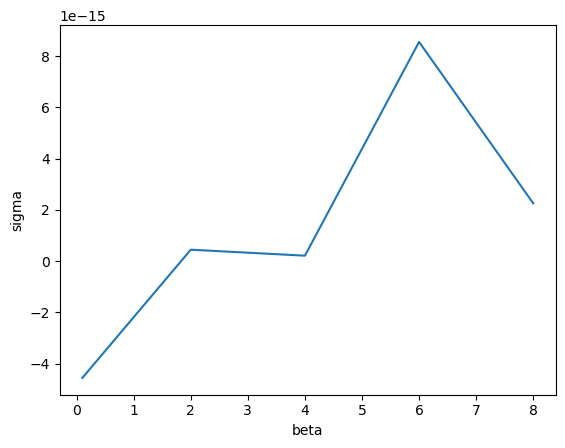

In [13]:
plt.figure()
plt.plot(1/temperature_list,Condenstate_list)
plt.xlabel('beta')
plt.ylabel('sigma')

画图

In [14]:
# beta = 1/temperature_list
# plt.figure(dpi=300,figsize=(8,6))
# # plt.subplot(221)
# plt.plot(beta,Condenstate_list,label=r'asdf')
# plt.ylabel(r'$\pi condenstate$')
# plt.xlabel(r'$\beta = 1/T$')

In [15]:
# beta = np.arange(0,step*delta_beta,delta_beta)+delta_beta
# Sigma_condensed = np.zeros((step),dtype=np.complex128)
# Sigma_condensed_ED = np.zeros((step),dtype=np.complex128)
# Pi_condensed = np.zeros((step),dtype=np.complex128)
# Pi_condensed_ED = np.zeros((step),dtype=np.complex128)
# # rho_condensed = np.zeros((step))

# for j in range(n_qubit): #遍历点
#     Num_sigma = 0
#     Num_sigma_ED = 0
#     Num_pi = 0
#     Num_pi_ED = 0
#     temp = np.ones((2**n_qubit),dtype=np.complex128)
#     for i in range(step): # beta
#         Den = 0
#         temp *= den[:,i]
#         print(temp)
#         for k in range(2**n_qubit): # different initial state
#             Num_sigma += num_sigma[k+j*2**n_qubit,i]*temp[k]
#             Num_sigma_ED += num_sigma_ED[k+j*2**n_qubit,i]*temp[k]
#             Num_pi += num_pi[k+j*2**n_qubit,i]*temp[k]
#             Num_pi_ED += num_pi_ED[k+j*2**n_qubit,i]*temp[k]
#             Den += temp[k]
#             Sigma_condensed[i] = Num_sigma/Den
#             Sigma_condensed_ED[i] = Num_sigma_ED/Den
#             Pi_condensed[i] = Num_pi/Den
#             Pi_condensed_ED[i] = Num_pi_ED/Den
#             # print("Sigma_condensed:",Sigma_condensed,"\n Sigma_condensed_ED:",Sigma_condensed_ED,"\n Pi_condensed:",Pi_condensed,Pi_condensed_ED,'\n\n\n')
#     rho_condensed = Sigma_condensed*Sigma_condensed + Pi_condensed*Pi_condensed
#     plt.figure(dpi=300,figsize=(8,6)) # plot
#     plt.subplot(221)
#     plt.plot(beta,Sigma_condensed,label=r'$e^{- i \Delta \beta A}$')
#     plt.plot(beta,Sigma_condensed_ED,'.',label=r'$e^{- \Delta \beta H}$')
#     plt.plot(beta,ED_sigma[j,:],'*',label='ED')
#     plt.ylabel('sigma condensed')
#     plt.xlabel('beta')
#     plt.ylim(-.001,0.08)
#     plt.legend()
#     plt.subplot(222)
#     plt.plot(beta,Pi_condensed,label=r'$e^{- i \Delta \beta A}$')
#     plt.plot(beta,Pi_condensed_ED,'.',label=r'$e^{- \Delta \beta H}$')
#     plt.plot(beta,ED_sigma[j,:],'*',label='ED')
#     plt.ylabel('pi condensed')
#     plt.xlabel('beta')
#     # plt.ylim(-.001,0.07)
#     plt.legend()
#     plt.subplot(223)
#     plt.plot(beta,rho_condensed,label=r'$e^{- i \Delta \beta A}$')
#     plt.ylabel('rho condensed')
#     plt.xlabel('beta')
#     plt.ylim(-.001,0.08)
#     plt.legend()
#     plt.suptitle("position:"+str(j))
#     path = "./img/" + str(date.today()) + "_position" + str(j) + ".png"
#     plt.savefig(path)
#     print('position in:',j,'\nSigma condensed:\n',Sigma_condensed,'\n Sgima condensed ED:\n',Sigma_condensed_ED,'\n\n Pi condensed:\n',Pi_condensed,'\n Pi condensed ED: \n',Pi_condensed_ED,'\n\n')
# # print(beta,'\n',Sigma_condensed,'\n',Pi_condensed)

In [16]:
time_end = time.time()
print('sum time',time_end-time_start)

sum time 1864.5540733337402
